# Regression Problem

### 1. Import necessary libraries:

In [51]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from mltools.regression_tools import LinearRegressor
from mltools import regression_tools as RT

### 2. Load data as a Pandas DataFrame:

In [52]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [53]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

In [54]:
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')


# Separando el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformando los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')


# Ajustando la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)


df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraer las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unir los DataFrames/series
df_final = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

In [55]:
# Convertir la columna "FranjaHoraria" a tipo int
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)


In [56]:
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

In [57]:
df_final

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion
0,2015,1,1,3,0,0.000,0.000000
2192,2015,1,1,3,3,0.000,0.000000
4384,2015,1,1,3,6,0.000,0.027848
6576,2015,1,1,3,9,414536.220,0.235443
8768,2015,1,1,3,12,1193085.200,0.263291
...,...,...,...,...,...,...,...
8767,2020,12,31,3,9,32165.098,0.011194
10959,2020,12,31,3,12,75464.914,0.024876
13151,2020,12,31,3,15,10270.279,0.001244
15343,2020,12,31,3,18,0.000,0.000000


In [58]:
df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes


df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

In [59]:
df_final

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
0,2015,1,1,3,0,0.000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2192,2015,1,1,3,3,0.000,0.000000,0.000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
4384,2015,1,1,3,6,0.000,0.027848,0.000,0.000,NaN,NaN,0.000000,0.000000,NaN,NaN
6576,2015,1,1,3,9,414536.220,0.235443,0.000,0.000,NaN,NaN,0.027848,0.000000,NaN,NaN
8768,2015,1,1,3,12,1193085.200,0.263291,414536.220,0.000,NaN,NaN,0.235443,0.027848,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8767,2020,12,31,3,9,32165.098,0.011194,0.000,0.000,147171.42,353766.8,0.002902,0.000000,0.046020,0.251244
10959,2020,12,31,3,12,75464.914,0.024876,32165.098,0.000,228807.36,1009271.3,0.011194,0.002902,0.073383,0.276534
13151,2020,12,31,3,15,10270.279,0.001244,75464.914,32165.098,236625.10,423595.5,0.024876,0.011194,0.024461,0.050580
15343,2020,12,31,3,18,0.000,0.000000,10270.279,75464.914,0.00,0.0,0.001244,0.024876,0.000000,0.000415


In [60]:
df_final.describe()

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
count,17536.000000,17536.000000,17536.000000,17536.000000,17536.00000,1.753600e+04,17536.000000,1.753500e+04,1.753400e+04,1.752800e+04,1.461600e+04,17535.000000,17534.000000,17528.000000,14616.000000
mean,2017.500456,6.521898,15.732664,3.000000,10.50000,4.729477e+05,0.079512,4.729747e+05,4.730017e+05,4.731569e+05,4.726322e+05,0.079517,0.079521,0.079546,0.081055
std,1.708230,3.449085,8.801621,1.999601,6.87406,7.341697e+05,0.117820,7.341820e+05,7.341942e+05,7.342718e+05,7.348932e+05,0.117822,0.117823,0.117836,0.119549
min,2015.000000,1.000000,1.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,8.000000,1.000000,5.25000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000422
50%,2017.500000,7.000000,16.000000,3.000000,10.50000,0.000000e+00,0.010896,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.010896,0.010896,0.010896,0.011759
75%,2019.000000,10.000000,23.000000,5.000000,15.75000,7.341657e+05,0.127996,7.341787e+05,7.341917e+05,7.346999e+05,7.311085e+05,0.127996,0.127996,0.128109,0.129854
max,2020.000000,12.000000,31.000000,6.000000,21.00000,3.017838e+06,0.537553,3.017838e+06,3.017838e+06,3.017838e+06,3.017838e+06,0.537553,0.537553,0.537553,0.537553


In [61]:
df_final = df_final.dropna()

In [62]:
# Define input and output matrices
INPUTS = ['ANNO', 'MES', 'DIA', 'FranjaHoraria', 'Irradiacion',	'Irradiacion_lag1',	'Irradiacion_lag2',	'Irradiacion_lag8',	'Irradiacion_lag365',	'Utilizacion_lag1',	'Utilizacion_lag2',	'Utilizacion_lag8',	'Utilizacion_lag365']
OUTPUT = 'Utilizacion'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_final[INPUTS]
y = df_final[OUTPUT]

## Divide the data into training and test sets ---------------------------------------------------
#X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                    test_size=0.2,  #percentage of test data
#                                                    random_state=0) #seed for replication
## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]



## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Utilizacion'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Utilizacion'] = y_test

X_train.head()

,ANNO,MES,DIA,FranjaHoraria,Irradiacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
365,2016,1,1,0,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000
2557,2016,1,1,3,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000
4749,2016,1,1,6,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.018987,0.027848
6941,2016,1,1,9,343723.03,0.00,0.0,226636.55,414536.22,0.020886,0.000000,0.164135,0.235443
9133,2016,1,1,12,734204.70,343723.03,0.0,806571.10,1193085.20,0.197468,0.020886,0.206329,0.263291


In [63]:
# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

In [100]:
## Inputs of the model. Change accordingly to perform variable selection
#INPUTS_MLP_NUM = ['ANNO', 'MES', 'DIA', 'FranjaHoraria', 'Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_MLP_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
#INPUTS_MLP_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_MLP_CAT = [] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.0001,0.001,0.01], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(5,),(13,),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Irradiacion',
                                                                          'Irradiacion_lag1',
                                                                          'Irradiacion_lag2',
                                                                          'Irradiacion_lag8',
                                                                          'Irradiacion_lag365',
                                                                          'Utilizacion_lag1',
                                                                          'Utilizacion_lag2',
                                                                          'Utilizacion_lag8',
                                                                          'Utilizacion_lag365']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('MLP',
                                        MLPRegressor(activation='logistic',
                                                     max_iter=450,
                                                     random_state=150,
                                                     solver='lbfgs',
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [0.0001, 0.001, 0.01],
                         'MLP__hidden_layer_sizes': [(5,), (13,), (20,),
                                                     (25,)]},
             scoring='neg_mean_squared_error')

In [101]:
# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns

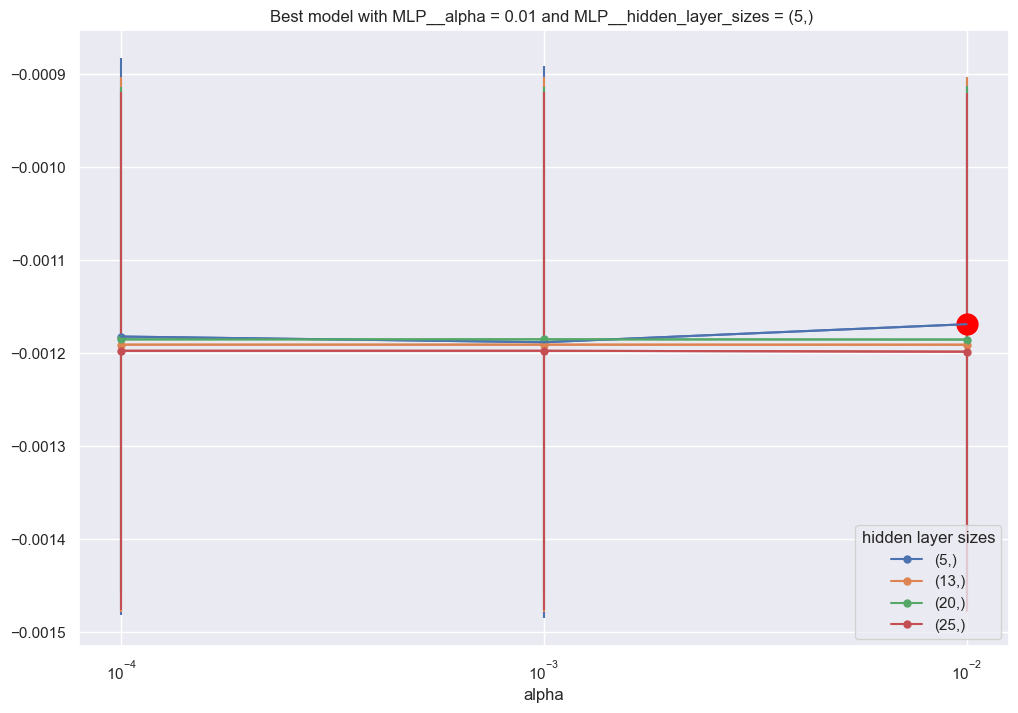

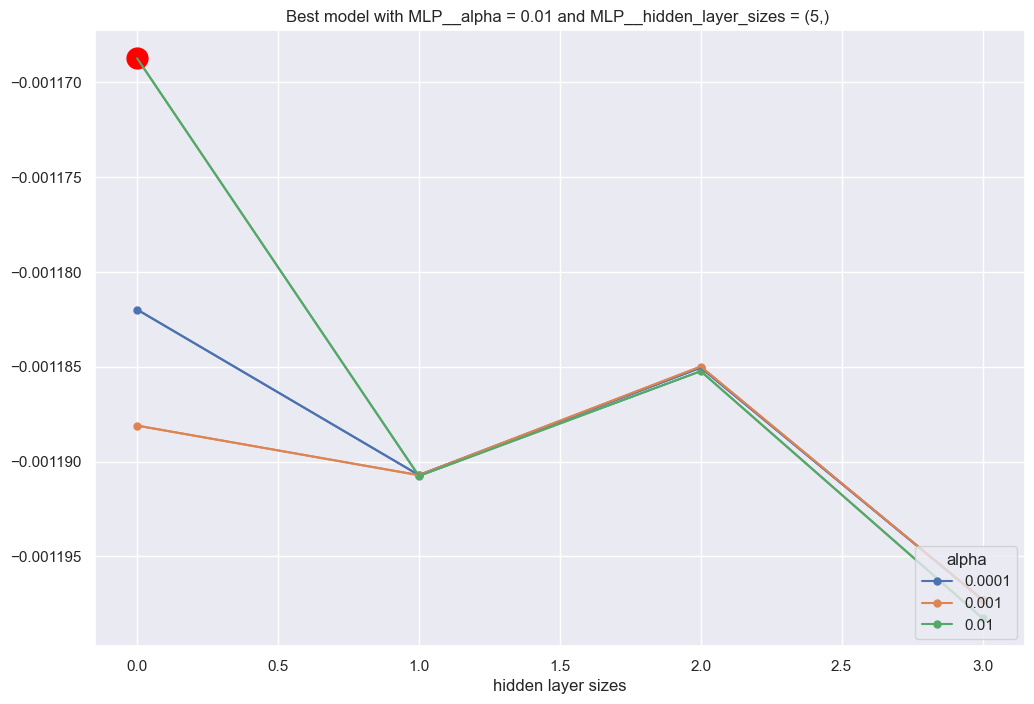

In [102]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [103]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [9, 5, 1] MLP network.

Sensitivity measures of each output:

$Y 

                             mean       std  mean_squared
num__Irradiacion         0.090664  0.008416      0.091054
num__Irradiacion_lag1   -0.057475  0.007247      0.057930
num__Irradiacion_lag2    0.020667  0.003500      0.020961
num__Irradiacion_lag8   -0.036295  0.003146      0.036431
num__Irradiacion_lag365 -0.018450  0.002316      0.018595
num__Utilizacion_lag1    0.065352  0.005879      0.065616
num__Utilizacion_lag2   -0.019891  0.002518      0.020050
num__Utilizacion_lag8    0.043201  0.004719      0.043458
num__Utilizacion_lag365  0.020785  0.004443      0.021254


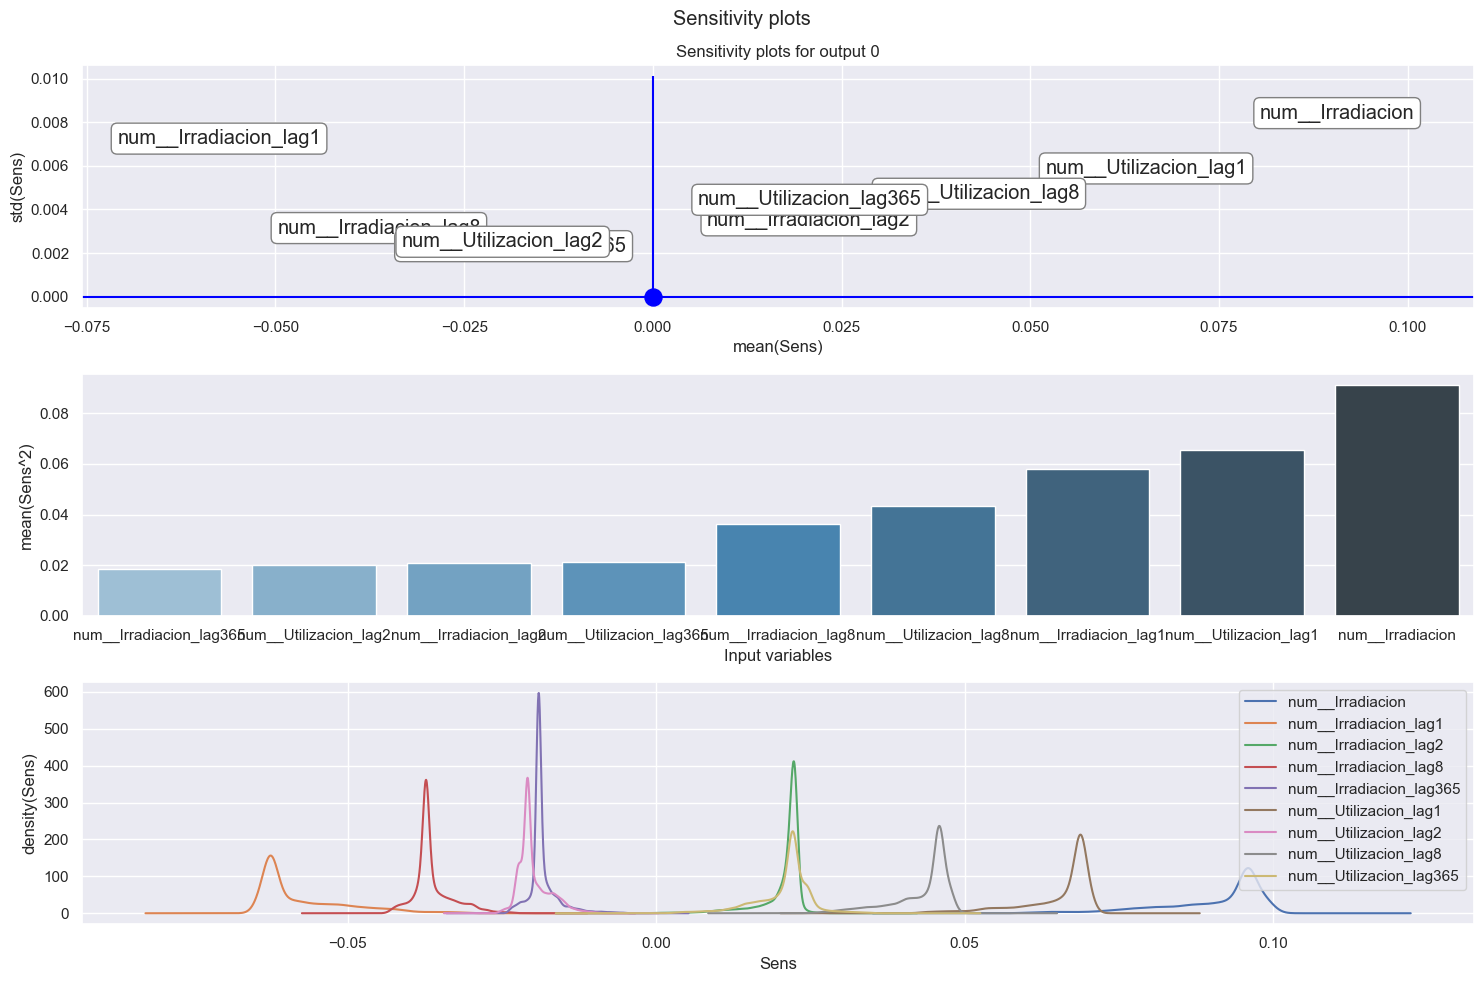

In [104]:
sensmlp.plot()

In [105]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Utilizacion'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['Utilizacion'], dfTS_eval['MLP_pred']))

Training MAE: 0.020826005220685243
Test MAE: 0.020626879882356248
Training RMSE: 0.033708006511432805
Test RMSE: 0.032557316730601416
Training R2: 0.9171459062685258
Test R2: 0.9097977404773583


In [106]:
dfTR_eval

,ANNO,MES,DIA,FranjaHoraria,Irradiacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365,Utilizacion,MLP_pred,residuals
365,2016,1,1,0,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000974,-0.000974
2557,2016,1,1,3,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000974,-0.000974
4749,2016,1,1,6,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.018987,0.027848,0.020886,0.013592,0.007294
6941,2016,1,1,9,343723.03,0.00,0.0,226636.55,414536.22,0.020886,0.000000,0.164135,0.235443,0.197468,0.149673,0.047795
9133,2016,1,1,12,734204.70,343723.03,0.0,806571.10,1193085.20,0.197468,0.020886,0.206329,0.263291,0.088608,0.244352,-0.155745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1826,2020,1,1,0,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.041415,0.000000,0.008602,-0.008602
4018,2020,1,1,3,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.039405,0.000000,0.008225,-0.008225
6210,2020,1,1,6,0.00,0.00,0.0,0.00,0.00,0.000000,0.000000,0.003317,0.041415,0.031509,0.009914,0.021595
8402,2020,1,1,9,353766.80,0.00,0.0,343273.70,423226.70,0.031509,0.000000,0.149668,0.184158,0.251244,0.135423,0.115821


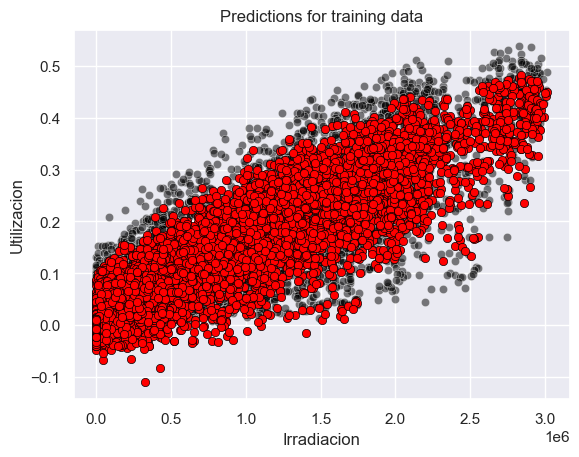

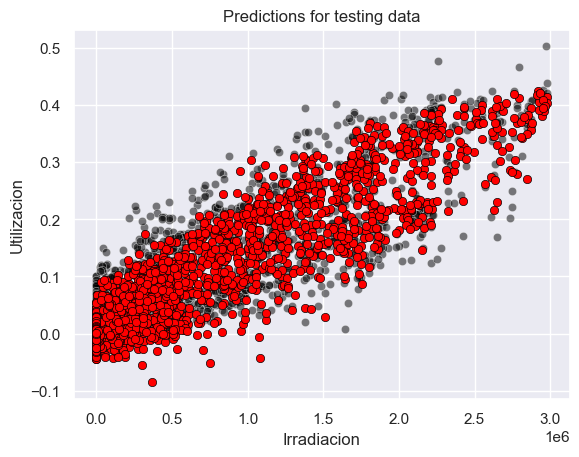

In [109]:
### Plot predictions of the model
sns.scatterplot(x='Irradiacion', y='Utilizacion', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='Irradiacion', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='Irradiacion', y='Utilizacion', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='Irradiacion', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for testing data')
plt.show()

In [110]:
dfTR_eval.dtypes


ANNO                    int64
MES                     int64
DIA                     int64
FranjaHoraria           int32
Irradiacion           float64
Irradiacion_lag1      float64
Irradiacion_lag2      float64
Irradiacion_lag8      float64
Irradiacion_lag365    float64
Utilizacion_lag1      float64
Utilizacion_lag2      float64
Utilizacion_lag8      float64
Utilizacion_lag365    float64
Utilizacion           float64
MLP_pred              float64
residuals             float64
dtype: object

c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


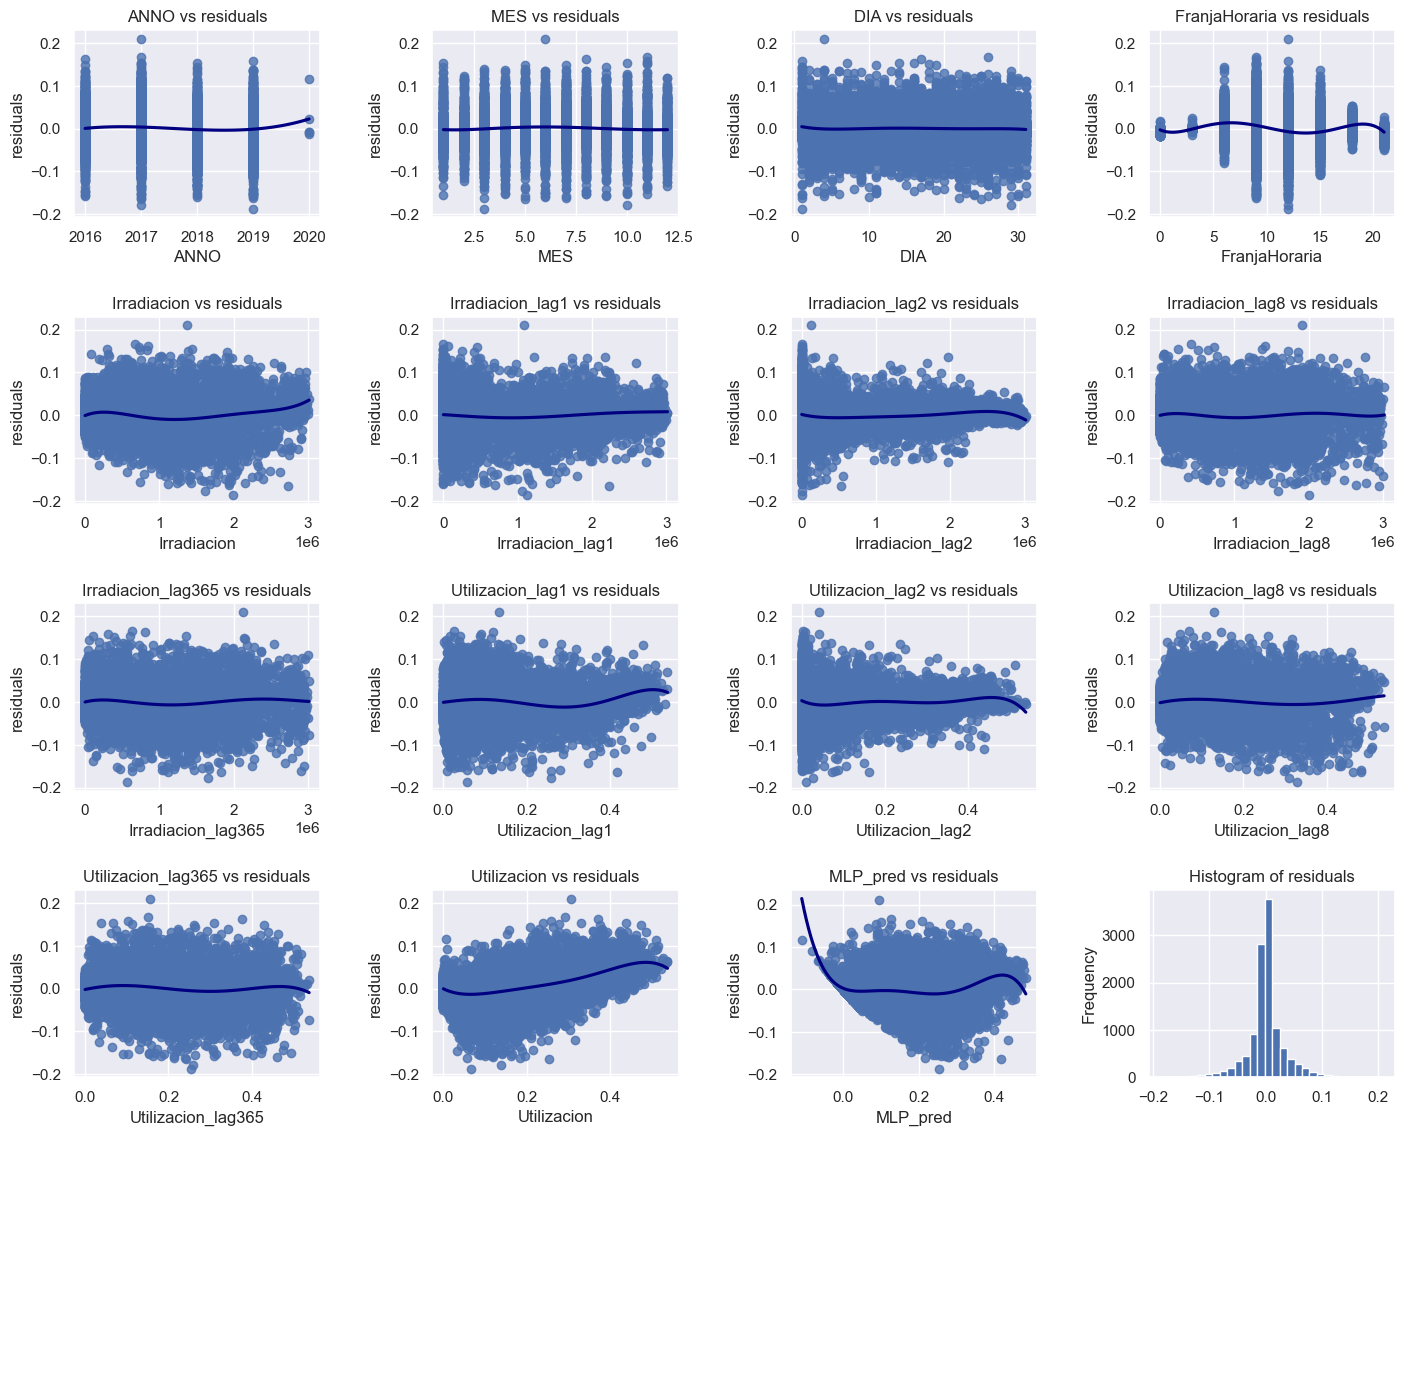

In [111]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'Utilizacion', figsize=[15,15])

In [71]:
# df_final del 1 de enero de 2017
df_final.loc[(df_final['ANNO'] == 2015) & (df_final['MES'] == 1) & (df_final['DIA'] == 1) & (df_final['FranjaHoraria'] == '12')]

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
8768,2015,1,1,3,12,1193085.2,0.263291,414536.22,0.0,NaN,NaN,0.235443,0.027848,NaN,NaN


In [72]:
df_final.loc[(df_final['ANNO'] == 2016) & (df_final['MES'] == 1) & (df_final['DIA'] == 1) & (df_final['FranjaHoraria'] == '12')]

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_lag1,Irradiacion_lag2,Irradiacion_lag8,Irradiacion_lag365,Utilizacion_lag1,Utilizacion_lag2,Utilizacion_lag8,Utilizacion_lag365
9133,2016,1,1,4,12,734204.7,0.088608,343723.03,0.0,806571.1,1193085.2,0.197468,0.020886,0.206329,0.263291


In [65]:
df_final.isnull().sum()

ANNO                     0
MES                      0
DIA                      0
DIASEM                   0
FranjaHoraria            0
Irradiacion              0
Utilizacion              0
Irradiacion_lag1         1
Irradiacion_lag2         2
Irradiacion_lag8         8
Irradiacion_lag365    2920
Utilizacion_lag1         1
Utilizacion_lag2         2
Utilizacion_lag8         8
Utilizacion_lag365    2920
dtype: int64

In [58]:
# Eliminar valores nulos
df_final = df_final.dropna()
df_final

,ANNO,MES,DIA,DIASEM,FranjaHoraria,Irradiacion,Utilizacion,Irradiacion_pasada,Utilizacion_pasada
2192,2015,1,1,3,03,0.000,0.000000,0.000,0.000000
4384,2015,1,1,3,06,0.000,0.027848,0.000,0.000000
6576,2015,1,1,3,09,414536.220,0.235443,0.000,0.027848
8768,2015,1,1,3,12,1193085.200,0.263291,414536.220,0.235443
10960,2015,1,1,3,15,481816.380,0.039241,1193085.200,0.263291
...,...,...,...,...,...,...,...,...,...
8767,2020,12,31,3,09,32165.098,0.011194,0.000,0.002902
10959,2020,12,31,3,12,75464.914,0.024876,32165.098,0.011194
13151,2020,12,31,3,15,10270.279,0.001244,75464.914,0.024876
15343,2020,12,31,3,18,0.000,0.000000,10270.279,0.001244


### 3. Split the data into training and test sets:

In [5]:
# Define input and output matrices:
INPUTS = ['IRRADH00', 'IRRADH03', 'IRRADH06', 'IRRADH09', 'IRRADH12',
          'IRRADH15', 'IRRADH18', 'IRRADH21', 'ANNO', 'MES', 'DIA', 'DIASEM']
OUTPUTS = ['UTILH00', 'UTILH03', 'UTILH06', 'UTILH09', 
          'UTILH12', 'UTILH15', 'UTILH18', 'UTILH21']

X = df[INPUTS]
Y = df[OUTPUTS]

# Split:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.3,  # Percentage of test data
                                                    random_state=0) # Seed for replication

In [6]:
# Create dataset to store model predictions:
dfTR_eval = X_train.copy()
dfTR_eval[OUTPUTS] = Y_train

dfTS_eval = X_test.copy()
dfTS_eval[OUTPUTS] = Y_test

### 4. Training of Linear Regression Models (Deprecated):

As it has been indicated that the solar utilization depends on irradiation from a given time interval, we will be considering separate linear regression models for each hour.

In [7]:
hours = ['00', '03', '06', '09', '12', '15', '18', '21']

# Initialize a dictionary to store the trained models for each hour
# and a second one to store the Cross-Validation scores for each trained model:
hourly_models   = {}
CV_score_hourly = {}
summary_hourly  = {}
metrics_hourly  = {}

# Train a linear regression model for each hour:
for hour in hours:

    # Define input and output features for the current hour:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    
    # Create input and output matrices for the current hour:
    X_train_hourly = X_train[inputs_hourly]
    y_train_hourly = Y_train[output_hourly]

    X_test_hourly  = X_test[inputs_hourly]
    
    # ----- 
    # -----

    # Train a linear regression model for the current hour:
    INPUTS_LR = inputs_hourly

    # Preparation of the numeric variables by scaling:
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    # Creation of a preprocessor to perform the steps defined above:
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, INPUTS_LR)])

    # Establishment the Linear Regression Model within a Pipeline:
    LinReg_fit_h = Pipeline(steps=[('Prep',preprocessor), 
                        ('LinReg',LinearRegressor(fit_intercept=True))]) 

    # Train model:
    LinReg_fit_h.fit(X_train_hourly, y_train_hourly);
    
    # Store the trained model in the dictionary:
    hourly_models[hour] = LinReg_fit_h

    # ----- 
    # -----

    # Store Cross-Validation score:
    CV_score_h = cross_val_score(LinReg_fit_h, X_train_hourly, y_train_hourly, cv=10, scoring='neg_root_mean_squared_error').mean()
    CV_score_hourly[hour] = CV_score_h

    # -----
    # -----

    # Information about the model trained:
    summary_h = RT.summaryLinReg(LinReg_fit_h, X_train_hourly, y_train_hourly)
    summary_hourly[hour] = summary_h

    # -----
    # -----

    # Model performance metrics:
    dfTR_eval[output_hourly + '_pred'] = LinReg_fit_h.predict(X_train_hourly)
    dfTS_eval[output_hourly + '_pred'] = LinReg_fit_h.predict(X_test_hourly)

    # Training and test MAE - Mean Absolute error
    mae_tr_h = mean_absolute_error(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred'])
    mae_ts_h = mean_absolute_error(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred'])

    # Training and test RMSE - Root Mean Square Error
    rmse_tr_h = math.sqrt(mean_squared_error(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred']))
    rmse_ts_h = math.sqrt(mean_squared_error(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred']))

    # Training and test r^2 
    r2_tr_h = r2_score(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred'])
    r2_ts_h = r2_score(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred'])
    
    metrics_hourly[hour] = {'mae_tr_' + hour: mae_tr_h, 'mae_ts_' + hour: mae_ts_h,
                            'rmse_tr_' + hour: rmse_tr_h, 'rmse_ts_' + hour: rmse_ts_h,
                            'r2_tr_' + hour: r2_tr_h, 'r2_ts_' + hour: r2_ts_h} 

In [8]:
print("CV negative RMSE per time interval is:\n")
for key, value in CV_score_hourly.items():
    print(f"{key}: {value}")

CV negative RMSE per time interval is:

00: -0.0016302126706607086
03: -0.006360087538595756
06: -0.03768178725968737
09: -0.07104960836432125
12: -0.07232097189778289
15: -0.036281663767392766
18: -0.0035655914772534866
21: -0.0013063064756179488


In [9]:
print("Information about each model trained per time interval:\n")
for key, value in summary_hourly.items():
    print(f"{key}: {value}")

Information about each model trained per time interval:

00:                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     13.08
Date:                Sat, 06 Apr 2024   Prob (F-statistic):           1.79e-10
Time:                        17:59:19   Log-Likelihood:                 7521.2
No. Observations:                1534   AIC:                        -1.503e+04
Df Residuals:                    1529   BIC:                        -1.501e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [10]:
print("Mean Absolute Error per time interval:\n")
for key, value in metrics_hourly.items():
    print(f"{key}: {value}")

Mean Absolute Error per time interval:

00: {'mae_tr_00': 0.000969484055321099, 'mae_ts_00': 0.000994372133952528, 'rmse_tr_00': 0.0017964719972353908, 'rmse_ts_00': 0.0014260563522128205, 'r2_tr_00': 0.03307521521915102, 'r2_ts_00': 0.03532617155294571}
03: {'mae_tr_03': 0.00418413046720633, 'mae_ts_03': 0.003964369122859611, 'rmse_tr_03': 0.006354551771456234, 'rmse_ts_03': 0.005810475522118052, 'r2_tr_03': 0.2247348918672898, 'r2_ts_03': 0.21594727068388864}
06: {'mae_tr_06': 0.02992025372201826, 'mae_ts_06': 0.028956899892823212, 'rmse_tr_06': 0.03756401925762646, 'rmse_ts_06': 0.03718260963882308, 'r2_tr_06': 0.560292257034581, 'r2_ts_06': 0.578704586319022}
09: {'mae_tr_09': 0.05681786977568487, 'mae_ts_09': 0.05487154194119162, 'rmse_tr_09': 0.07086681981391836, 'rmse_ts_09': 0.06903484015228267, 'r2_tr_09': 0.6445938262804963, 'r2_ts_09': 0.6797630558462158}
12: {'mae_tr_12': 0.05572374234631118, 'mae_ts_12': 0.05388648080903992, 'rmse_tr_12': 0.0722182612413601, 'rmse_ts_12': 

c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\mltools\regression_tools.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuals'] = df[output_name] - df[pred]
c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


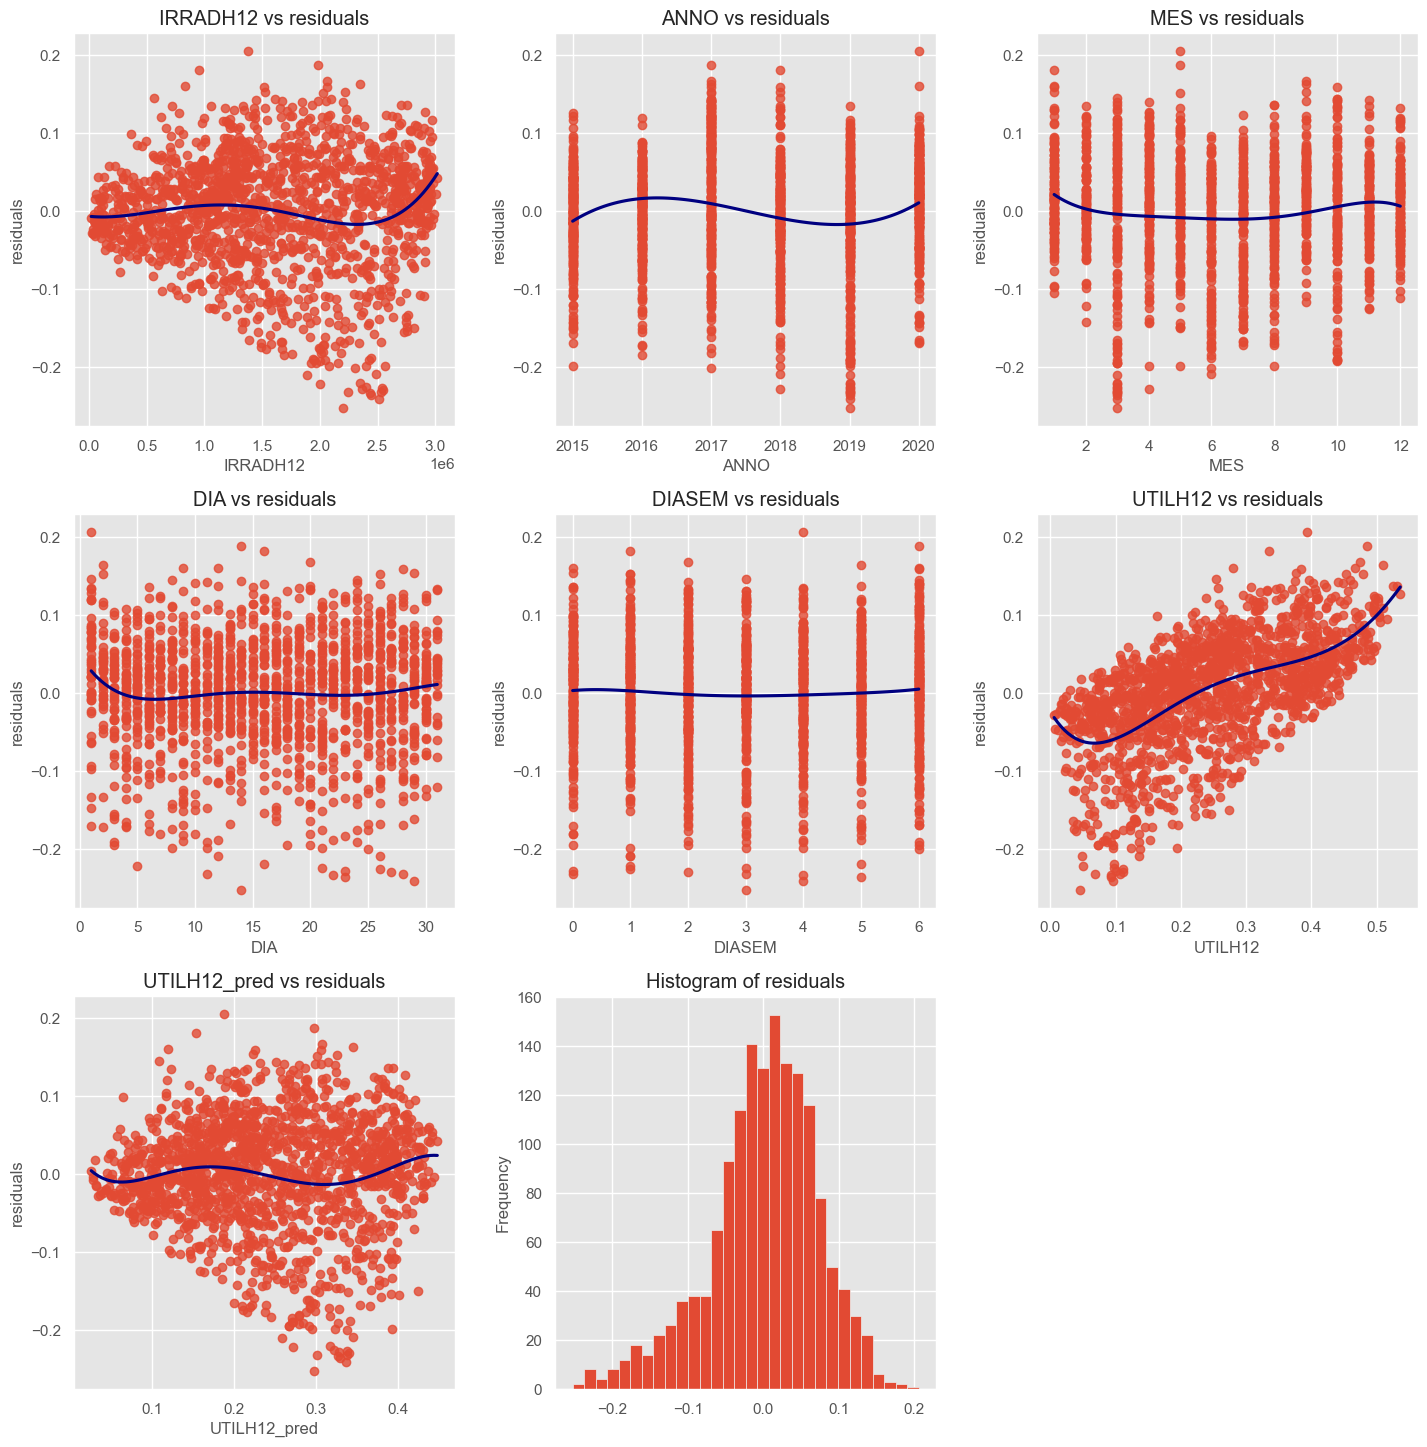

In [11]:
hours = ['12']

for hour in hours:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'

    dfTR_eval_h = dfTR_eval[inputs_hourly + [output_hourly, pred_hourly]]

    # Analysis of residuals
    RT.plotModelDiagnosis(dfTR_eval_h, pred_hourly, output_hourly, figsize=[15,15])

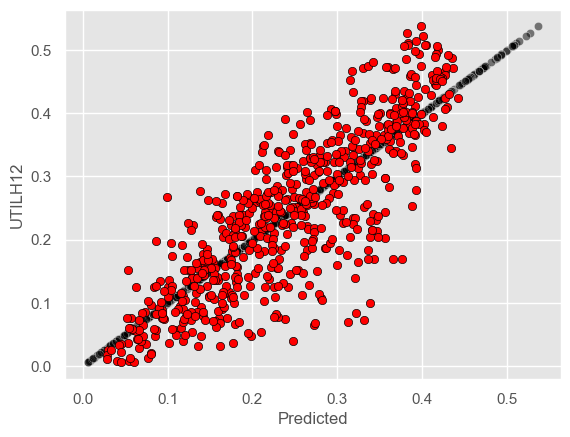

In [12]:
hours = ['12']

for hour in hours:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'

    # Visualize prediction with respect to real value
    sns.scatterplot(data=dfTS_eval, x = output_hourly, y = output_hourly, color='black', alpha=0.5)
    sns.scatterplot(data=dfTS_eval, x = pred_hourly, y = output_hourly, color='red', edgecolor='black')
    plt.xlabel('Predicted')
    plt.show()

### 5. Training of Linear Regression Models:

In [13]:
hours = ['00', '03', '06', '09', '12', '15', '18', '21']

# Initialize a dictionary to store the trained models for each hour
# and a second one to store the Cross-Validation scores for each trained model:
hourly_models   = {}
CV_score_hourly = {}
summary_hourly  = {}
metrics_hourly  = {}

# Train a linear regression model for each hour:
for hour in hours:

    # Define input and output features for the current hour:
    inputs_hourly = INPUTS
    
    output_hourly = 'UTILH' + hour
    
    # Create input and output matrices for the current hour:
    X_train_hourly = X_train[inputs_hourly]
    y_train_hourly = Y_train[output_hourly]

    X_test_hourly  = X_test[inputs_hourly]
    
    # ----- 
    # -----

    # Train a linear regression model for the current hour:
    INPUTS_LR = inputs_hourly

    # Preparation of the numeric variables by scaling:
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

    # Creation of a preprocessor to perform the steps defined above:
    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, INPUTS_LR)])

    # Establishment the Linear Regression Model within a Pipeline:
    LinReg_fit_h = Pipeline(steps=[('Prep',preprocessor), 
                        ('LinReg',LinearRegressor(fit_intercept=True))]) 

    # Train model:
    LinReg_fit_h.fit(X_train_hourly, y_train_hourly);
    
    # Store the trained model in the dictionary:
    hourly_models[hour] = LinReg_fit_h

    # ----- 
    # -----

    # Store Cross-Validation score:
    CV_score_h = cross_val_score(LinReg_fit_h, X_train_hourly, y_train_hourly, cv=10, scoring='neg_root_mean_squared_error').mean()
    CV_score_hourly[hour] = CV_score_h

    # -----
    # -----

    # Information about the model trained:
    summary_h = RT.summaryLinReg(LinReg_fit_h, X_train_hourly, y_train_hourly)
    summary_hourly[hour] = summary_h

    # -----
    # -----

    # Model performance metrics:
    dfTR_eval[output_hourly + '_pred'] = LinReg_fit_h.predict(X_train_hourly)
    dfTS_eval[output_hourly + '_pred'] = LinReg_fit_h.predict(X_test_hourly)

    # Training and test MAE - Mean Absolute error
    mae_tr_h = mean_absolute_error(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred'])
    mae_ts_h = mean_absolute_error(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred'])

    # Training and test RMSE - Root Mean Square Error
    rmse_tr_h = math.sqrt(mean_squared_error(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred']))
    rmse_ts_h = math.sqrt(mean_squared_error(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred']))

    # Training and test r^2 
    r2_tr_h = r2_score(dfTR_eval[output_hourly], dfTR_eval[output_hourly + '_pred'])
    r2_ts_h = r2_score(dfTS_eval[output_hourly], dfTS_eval[output_hourly + '_pred'])
    
    metrics_hourly[hour] = {'mae_tr_' + hour: mae_tr_h, 'mae_ts_' + hour: mae_ts_h,
                            'rmse_tr_' + hour: rmse_tr_h, 'rmse_ts_' + hour: rmse_ts_h,
                            'r2_tr_' + hour: r2_tr_h, 'r2_ts_' + hour: r2_ts_h} 

In [14]:
print("CV negative RMSE per time interval is:\n")
for key, value in CV_score_hourly.items():
    print(f"{key}: {value}")

CV negative RMSE per time interval is:

00: -0.001611888337630802
03: -0.005391057187930949
06: -0.029620617288252354
09: -0.07028778213122457
12: -0.07198591295679063
15: -0.03551981508987393
18: -0.003473651790702788
21: -0.0012623457161204323


In [15]:
print("Information about each model trained per time interval:\n")
for key, value in summary_hourly.items():
    print(f"{key}: {value}")

Information about each model trained per time interval:

00:                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     9.684
Date:                Sat, 06 Apr 2024   Prob (F-statistic):           1.67e-14
Time:                        17:59:26   Log-Likelihood:                 7538.0
No. Observations:                1534   AIC:                        -1.506e+04
Df Residuals:                    1524   BIC:                        -1.500e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [16]:
print("Mean Absolute Error per time interval:\n")
for key, value in metrics_hourly.items():
    print(f"{key}: {value}")

Mean Absolute Error per time interval:

00: {'mae_tr_00': 0.0009482901604461356, 'mae_ts_00': 0.0009824271000202234, 'rmse_tr_00': 0.0017768389563957213, 'rmse_ts_00': 0.0014078980737979975, 'r2_tr_00': 0.054094124181647496, 'r2_ts_00': 0.05973655794536237}
03: {'mae_tr_03': 0.0036980457825511355, 'mae_ts_03': 0.0034719969492825395, 'rmse_tr_03': 0.00536267102677528, 'rmse_ts_03': 0.00472178565264966, 'r2_tr_03': 0.44786827031912035, 'r2_ts_03': 0.4822328946902774}
06: {'mae_tr_06': 0.022354028133335858, 'mae_ts_06': 0.021356300735295694, 'rmse_tr_06': 0.029404776934035266, 'rmse_ts_06': 0.02863372009304117, 'r2_tr_06': 0.7305639005964051, 'r2_ts_06': 0.750159668548752}
09: {'mae_tr_09': 0.05542142397344956, 'mae_ts_09': 0.05332068208631467, 'rmse_tr_09': 0.06992524105156339, 'rmse_ts_09': 0.06810149533880665, 'r2_tr_09': 0.6539753612107835, 'r2_ts_09': 0.6883636696016056}
12: {'mae_tr_12': 0.055230492154848036, 'mae_ts_12': 0.053776717213871124, 'rmse_tr_12': 0.07170432411824121, 'rms

In [17]:
#hours = ['00', '03', '06', '09', '12', '15', '18', '21']
hours = ['12']
for hour in hours:
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'
    dfTS_h = dfTS_eval[INPUTS+[output_hourly,pred_hourly]]

dfTS_h.head()

,IRRADH00,IRRADH03,IRRADH06,IRRADH09,IRRADH12,IRRADH15,IRRADH18,IRRADH21,ANNO,MES,DIA,DIASEM,UTILH12,UTILH12_pred
264,0.0,0.0,483.06393,560354.50,1426041.1,615868.90,0.00,0.0,2015,9,22,1,0.252321,0.244352
1493,0.0,0.0,0.00000,283719.38,871021.8,375196.75,0.00,0.0,2019,2,2,5,0.141134,0.129394
314,0.0,0.0,0.00000,821588.90,1474602.4,525181.20,0.00,0.0,2015,11,11,2,0.262869,0.253749
1327,0.0,0.0,152238.84000,1933075.10,2696730.2,1912468.80,240846.55,0.0,2018,8,20,0,0.363673,0.380440
379,0.0,0.0,0.00000,338218.66,871586.3,556280.60,0.00,0.0,2016,1,15,4,0.115190,0.170062


c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\mltools\regression_tools.py:224: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuals'] = df[output_name] - df[pred]
c:\Users\Ainhoa\anaconda3\envs\ML\Lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


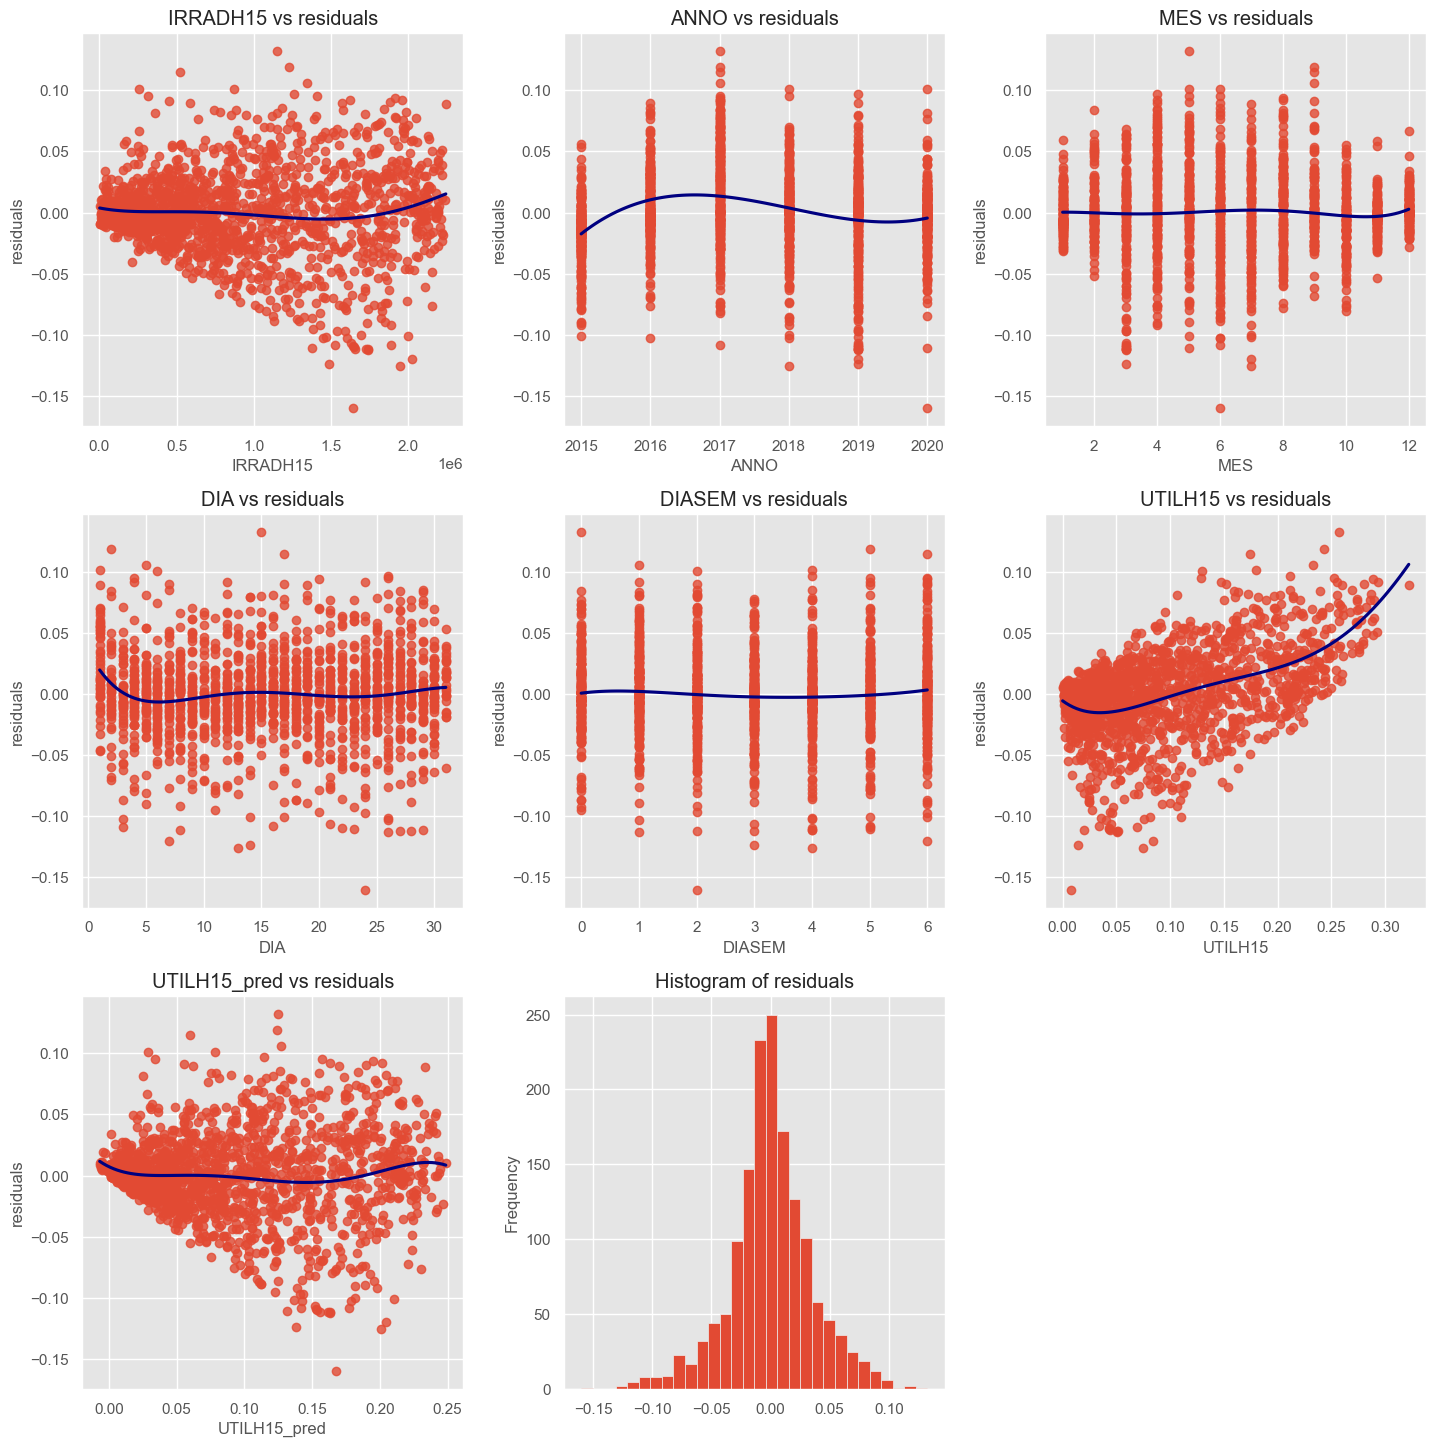

In [18]:
#hours = ['00', '03', '06', '09', '12', '15', '18', '21']
hours = ['15']

for hour in hours:
    inputs_hourly =  ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'

    dfTR_eval_h = dfTR_eval[inputs_hourly + [output_hourly, pred_hourly]]

    RT.plotModelDiagnosis(dfTR_eval_h, pred_hourly, output_hourly, figsize=[15,15])

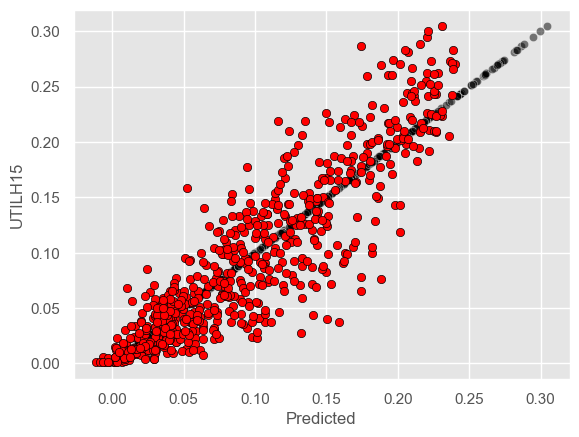

In [19]:
#hours = ['00', '03', '06', '09', '12', '15', '18', '21']
hours = ['15']

for hour in hours:
    inputs_hourly = ['IRRADH' + hour, 'ANNO', 'MES', 'DIA', 'DIASEM']
    output_hourly = 'UTILH' + hour
    pred_hourly   = output_hourly + '_pred'

    # Visualize prediction with respect to real value
    sns.scatterplot(data=dfTS_eval, x = output_hourly, y = output_hourly, color='black', alpha=0.5)
    sns.scatterplot(data=dfTS_eval, x = pred_hourly, y = output_hourly, color='red', edgecolor='black')
    plt.xlabel('Predicted')
    plt.show()